In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn.functional as F
import typing
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
os.chdir("../")
# from src.utils.get_datasets import getDataTF, getDataHF
from src.data.processing_data import Format
from src.models.pipelines import Pipeline
from src.models.encoders import TransformersEncoder, HierarchicalTransformersEncoder
from src.utils.models_utils import _confusion_matrix

2023-03-16 23:45:45.454047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 23:45:46.346942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 23:45:46.347050: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 23:45:46.347060: W tensorfl

In [2]:
from transformers import (
        BertModel,
        BertTokenizer,
        XLNetModel,
        XLNetTokenizer)

In [3]:
pd.set_option('display.max_columns', None)
sns.set_theme()

In [4]:
_dataset = "dyda_e"
_split = "train"
df = pd.read_csv(f"./inputs_data/data_{_dataset}_{_split}.csv", sep="|")
df.head()

,Utterance,Dialogue_ID,Label
0,"say , jim , how about going for a few beers af...",1,no emotion
1,you know that is tempting but is really not go...,1,no emotion
2,what do you mean ? it will help us to relax .,1,no emotion
3,do you really think so ? i don't . it will jus...,1,no emotion
4,i guess you are right.but what shall we do ? i...,1,no emotion


In [5]:
df.groupby("Dialogue_ID")["Label"].count().sort_values().mean()

7.8404389278647235

In [6]:
dimDialogAct, Contexts, Labels = Format(_dataset, 5, "concatenate").get_contexts_labels()

2023-03-16 23:45:53.464182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 23:45:54.267347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13581 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:82:00.0, compute capability: 7.5


In [7]:
# HierarchicalTransformersEncoder('prajjwal1/bert-tiny', 50).hierarchical_embeddings(Contexts[2][:1])

# Testing Pipeline working

In [8]:
_pipeline = Pipeline(
    _dataset,
    5,
    'bert-base-cased',
    "GRU",
    "separate")
_pipeline.summarize()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

2023-03-16 23:56:49.608966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-03-16 23:56:49.938057: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe8148e1ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-16 23:56:49.938106: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-03-16 23:56:49.945720: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-16 23:56:50.152298: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 1s 6ms/step


In [9]:
_pipeline.df_report

,dataset_name,encoder_model,decoder_model,performance
0,dyda_e,bert-base-cased,GRU,0.867476


In [10]:
_pipeline.confusion_matrix

array([[   2,    0,    6,    0,    0,   39,    0],
       [   2,    0,    0,    0,    2,   35,    0],
       [   0,    0,   17,    0,    7,   36,    0],
       [   0,    0,    0,    0,    0,    8,    0],
       [   0,    0,    4,    0,  151,  243,    0],
       [   4,    0,    7,    0,   71, 3044,    0],
       [   0,    0,    0,    0,    0,   27,    0]])

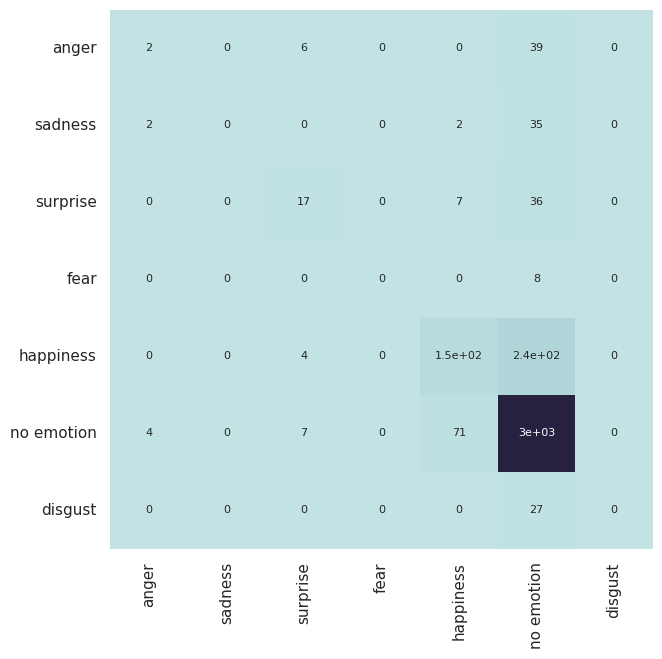

In [11]:
df_cm = pd.DataFrame(
    _pipeline.confusion_matrix,
    Format(_dataset, 5, "separate").get_distincts_labels(),
    Format(_dataset, 5, "separate").get_distincts_labels())
plt.figure(figsize=(7, 7))
sns.set(font_scale=1)
sns.heatmap(df_cm,
            annot=True,
            annot_kws={"size": 8},
            cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True), 
            cbar=False)
plt.savefig(f"../intent_classification/figs/{_dataset}_bert_gru.pdf")
plt.show()